## Salary Prediction & Cost Analysis System
The City of Baltimore publishes data about all of its employees, including their salaries. And these annual salaries can differ from their gross pay: Perhaps an employee works nightshift/overtime and earns more than their official salary; perhaps they are only employed for a part of the year and earn less.

In this project, we'll estimate what a typical city employee's gross pay will be based on their annual salary.

**Note**

Here are the steps we'll do:

- Data Acquisition—there will be a little of coding for you here

- Data Cleaning and Preparation

- Training—there will be a little bit here for you to do as well

- Validation—lots to do here

- Evaluation—lots to do here

# Data Acquisition

First up, let's load the libraries we need:

In [1]:
from sklearn.cluster import mean_shift
from sklearn.metrics import mean_absolute_error
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import sklearn.linear_model
import sklearn.model_selection
import sklearn.metrics

The Baltimore salaries data set is available in `Baltimore_City_Employee_Salaries_2011.csv`. This is a file and needs to be in the same directory as this notebook. Column 0 is the name of the employee, and we'll use it as an index. Column 4 is a date. (Note that we count columns starting with "0").

The pandas `read_csv` function reads it into a dataframe called `salaries`

In [2]:
salaries = pd.read_csv('Baltimore_City_Employee_Salaries_2011.csv', 
                       index_col=0, #colum 1 will be marked as index
                      parse_dates=[4]) # colum 5 will be parsed as datetime
salaries.head()

,JobTitle,AgencyID,Agency,HireDate,AnnualSalary,GrossPay
Name,,,,,,
"Aaron,Patricia G",Facilities/Office Services II,A03031,OED-Employment Dev,1979-10-24,$50845.00,$45505.94
"Aaron,Petra L",ASSISTANT STATE'S ATTORNEY,A29005,States Attorneys Office,2006-09-25,$56595.00,$51588.89
"Abaineh,Yohannes T",EPIDEMIOLOGIST,A65026,HLTH-Health Department,2009-07-23,$56500.00,$50633.26
"Abdal-Rahim,Naim A",EMT Firefighter,A64063,Fire Academy Recruits,2011-03-30,$33476.00,$3888.95
"Abdi,Ezekiel W",POLICE OFFICER,A99398,Police Department,2007-06-14,$50919.00,$51421.73


We'll use `.tail()` method to see the last few rows in a database. Use that now to look at
the end of the `salaries` dataframe.

In [3]:
salaries.tail() #will show us tail of the csv file

,JobTitle,AgencyID,Agency,HireDate,AnnualSalary,GrossPay
Name,,,,,,
"Lewis,Awanda S",SCHOOL HEALTH AIDE (10 MONTHS),A65104,HLTH-Health Department,2006-07-01,$23395.00,$21746.79
"Lewis,Bernard T",FIRE PUMP OPERATOR,A64120,Fire Department,1990-03-26,$61653.00,$59866.23
"Lewis,Brian C",POLICE OFFICER,A99322,Police Department,1998-04-20,$61672.00,$84219.58
"Lewis,Capri T",JTPA TRAINEE MOMR,W03T19,Youth Cust,2009-06-11,$15080.00,$1881.38
"Lewis,Carlos E",CARPENTER II,A50212,DPW-Water & Waste Water,1993-08-02,$34643.00,$29709.64


we can also use `.sample(5)` to get 5 random rows from the `salaries` dataframe.

In [4]:
salaries.sample(5) # find 5 sample rows to show

,JobTitle,AgencyID,Agency,HireDate,AnnualSalary,GrossPay
Name,,,,,,
"Fout Jr,Donald C",FIRE CAPTAIN,A64206,Fire Department,1981-07-06,$80644.00,$80736.83
"Freet,Adam R",EMT Firefighter,A64063,Fire Academy Recruits,2011-01-19,$33476.00,$10552.43
"Kearney,Thomas E",FIREFIGHTER,A64301,Fire Department,1992-08-31,$57776.00,$57288.67
"Katherine,Brower",CONTRACT SERV SPEC II,A67002,R&P-Administration,2011-05-02,$72800.00,$2668.75
"Woolfolk Jr,Lee",CIVIL ENG DRAFTING TECH II,A49103,TRANS-Highways,1998-11-30,$38807.00,$40796.04


# Data Preprocessing

## Preprocess the Data (Convert Strings to Numbers)

The `AnnualSalary` and `GrossPay` columns are strings and start with a `$`. We'll have to strip this off and convert these columns to floats.

In [5]:
salaries.AnnualSalary = salaries.AnnualSalary.str.strip('$').astype(float)
salaries.GrossPay = salaries.GrossPay.str.strip('$').astype(float)
salaries.head()



,JobTitle,AgencyID,Agency,HireDate,AnnualSalary,GrossPay
Name,,,,,,
"Aaron,Patricia G",Facilities/Office Services II,A03031,OED-Employment Dev,1979-10-24,50845.0,45505.94
"Aaron,Petra L",ASSISTANT STATE'S ATTORNEY,A29005,States Attorneys Office,2006-09-25,56595.0,51588.89
"Abaineh,Yohannes T",EPIDEMIOLOGIST,A65026,HLTH-Health Department,2009-07-23,56500.0,50633.26
"Abdal-Rahim,Naim A",EMT Firefighter,A64063,Fire Academy Recruits,2011-03-30,33476.0,3888.95
"Abdi,Ezekiel W",POLICE OFFICER,A99398,Police Department,2007-06-14,50919.0,51421.73


## Perform Exploratory Data Analysis

Create a scatterplot of annual salary versus gross pay.

<Axes: xlabel='AnnualSalary', ylabel='GrossPay'>

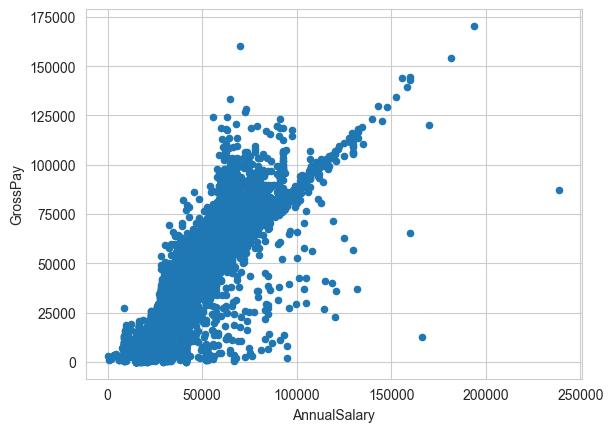

In [6]:
salaries.plot.scatter(x='AnnualSalary', y='GrossPay')

# Look for a Linear Relationship

It seems like there is a linear relationship in there, but it's obscured by a lot of noise.

Let's get a vibe for the data, and what we should expect to see in our machine generated model.

We will extract a tiny sample of it and do an approximation of the Theil-Sen algorithm by hand.

In [7]:
tiny_sample = salaries.sample(10)
tiny_sample

,JobTitle,AgencyID,Agency,HireDate,AnnualSalary,GrossPay
Name,,,,,,
"Roth,Michael R",FIRE CAPTAIN,A64065,Fire Department,1987-04-20,77863.0,78245.90
"Talley,Edward L",CONSTRUCTION ELECTRCL INSPEC I,A06035,Housing & Community Dev,2002-07-15,40828.0,37127.10
"Griffin,Michele L",PARKING CONTROL AGENT I,A90201,TRANS-Traffic,1987-05-21,32599.0,30395.13
"Shelton,Gwendolyn D",Facilities/Office Services II,A03090,OED-Employment Dev,2007-06-04,39694.0,35832.49
"Hicks,William A",MOTOR VEHICLE DRIVER I,B70105,DPW-Solid Waste,2004-11-22,30139.0,27712.13
"Lewis,Pearlie",JTPA TRAINEE MOMR,W08M38,TANF Cust,2011-01-31,15080.0,2030.00
"Bryant,Lisa",Facilities/Office Services I,A03085,OED-Employment Dev,2004-08-31,31199.0,28257.75
"McKnight,Abraham S",POLICE OFFICER,A99170,Police Department,2006-12-12,54125.0,68058.72
"Brunson,Sylvester",UTILITIES INSTALLER REPAIR SII,A50501,DPW-Water & Waste Water,1987-05-18,47604.0,52270.76


The next cell creates an image

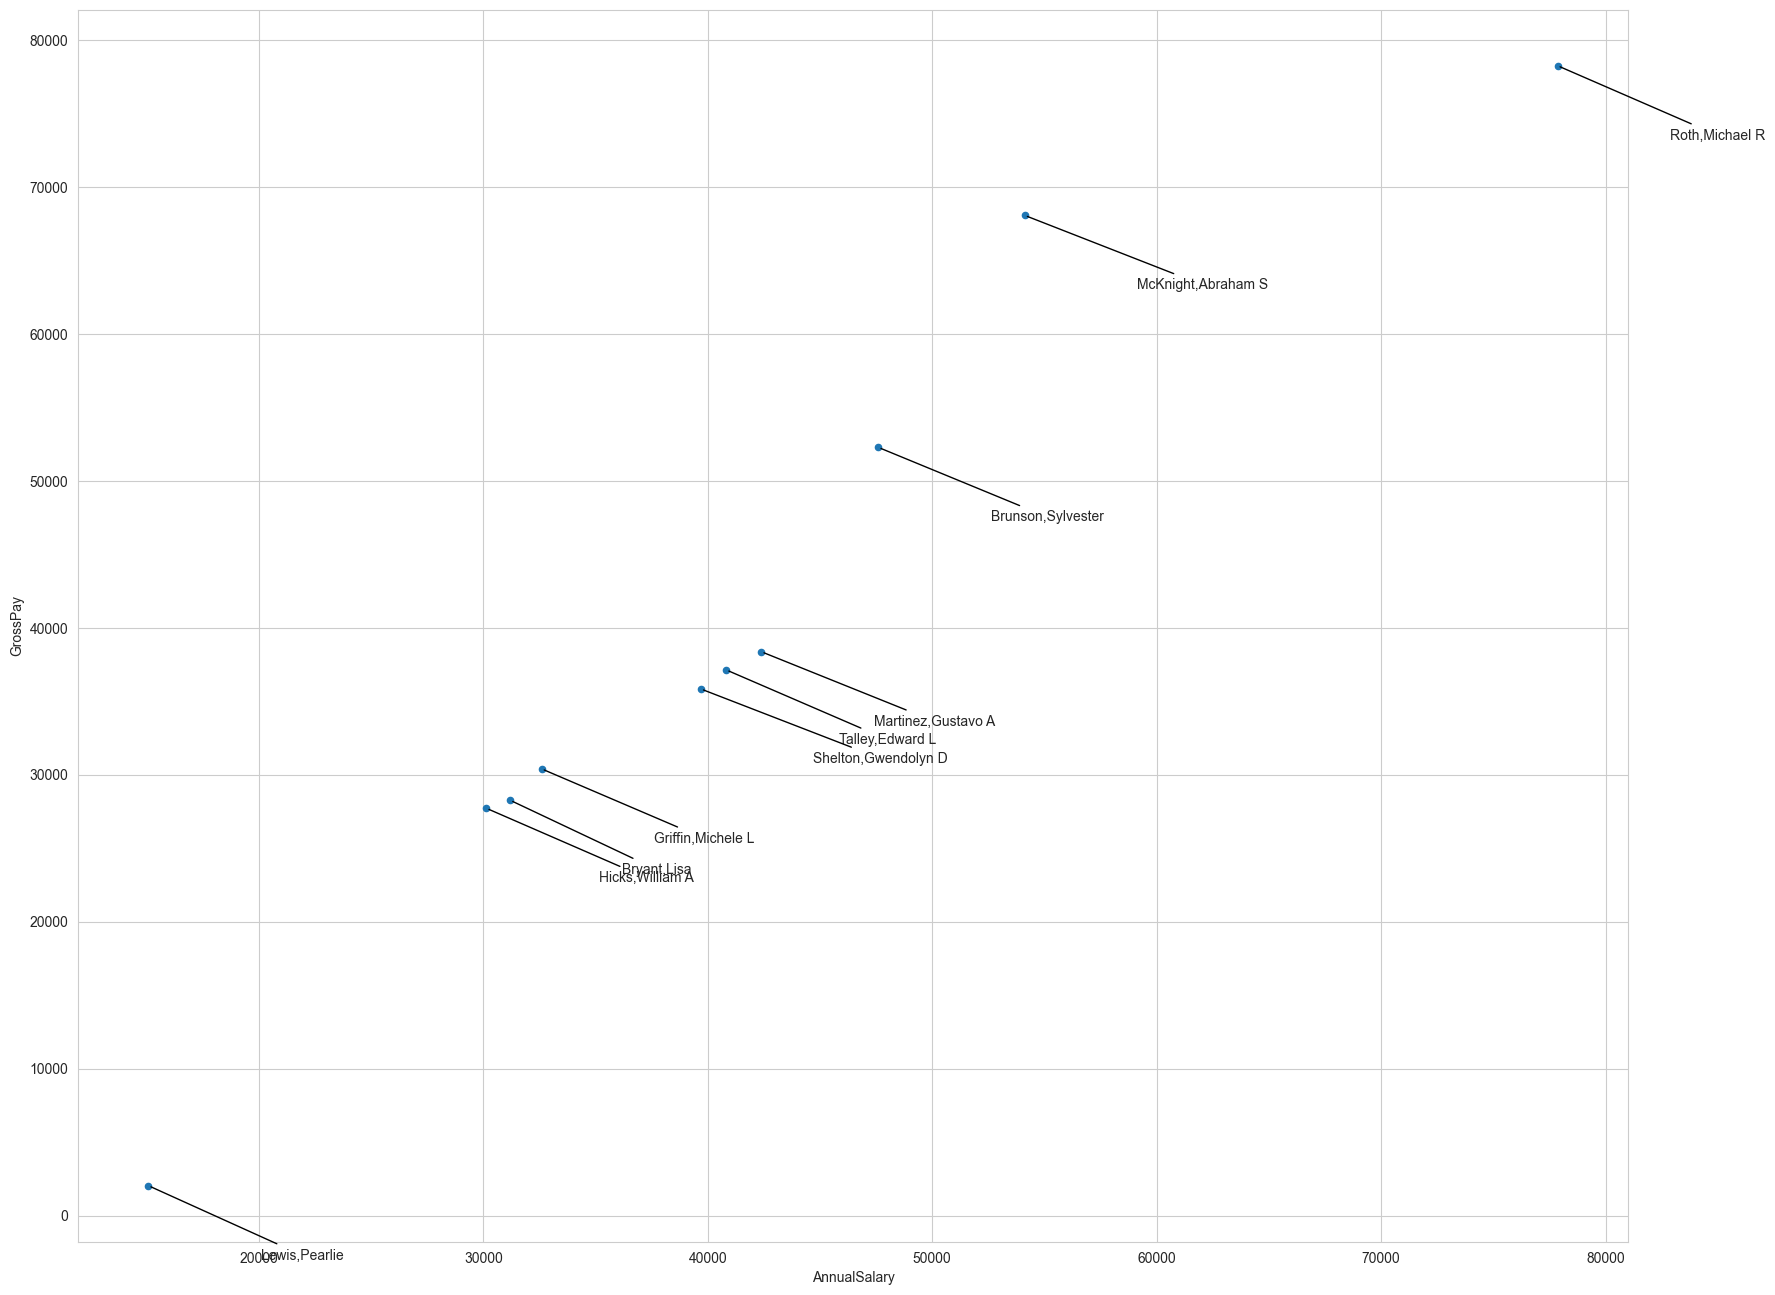

In [8]:
fig, ax = plt.subplots(figsize=(20,16))
tiny_sample.plot.scatter(x='AnnualSalary', y='GrossPay', ax=ax)
for name, details in tiny_sample.iterrows():
    ax.annotate(text=name, xy=(details.AnnualSalary,details.GrossPay), xytext=(details.AnnualSalary+5000, details.GrossPay-5000),
                arrowprops=dict(arrowstyle="-", color='black')
               )


The next cell will give you five random pairs of people to draw a line between. Draw them, and then **save the image into your
GitHub classroom repo so that we know that you've done it**.

In [9]:
for i in range(5):
    pair = tiny_sample.sample(2)
    first_name = pair.index[0]
    second_name = pair.index[1]
    print(f"""
Draw a line that goes through {first_name} and {second_name}. 

This should go through ({pair.AnnualSalary.iloc[0]},{pair.GrossPay.iloc[0]}) and ({pair.AnnualSalary.iloc[1]},{pair.GrossPay.iloc[1]})

It has a gradient (slope) of {(pair.GrossPay.iloc[1]-pair.GrossPay.iloc[0])/(pair.AnnualSalary.iloc[1]-pair.AnnualSalary.iloc[0])}

-----------------------------
""")


Draw a line that goes through Lewis,Pearlie and Griffin,Michele L. 

This should go through (15080.0,2030.0) and (32599.0,30395.13)

It has a gradient (slope) of 1.619106684171471

-----------------------------


Draw a line that goes through McKnight,Abraham S and Brunson,Sylvester. 

This should go through (54125.0,68058.72) and (47604.0,52270.76)

It has a gradient (slope) of 2.421094924091397

-----------------------------


Draw a line that goes through Hicks,William A and Griffin,Michele L. 

This should go through (30139.0,27712.13) and (32599.0,30395.13)

It has a gradient (slope) of 1.090650406504065

-----------------------------


Draw a line that goes through Brunson,Sylvester and Bryant,Lisa. 

This should go through (47604.0,52270.76) and (31199.0,28257.75)

It has a gradient (slope) of 1.4637616580310882

-----------------------------


Draw a line that goes through Brunson,Sylvester and Bryant,Lisa. 

This should go through (47604.0,52270.76) and (31199.0,28257.75)

It

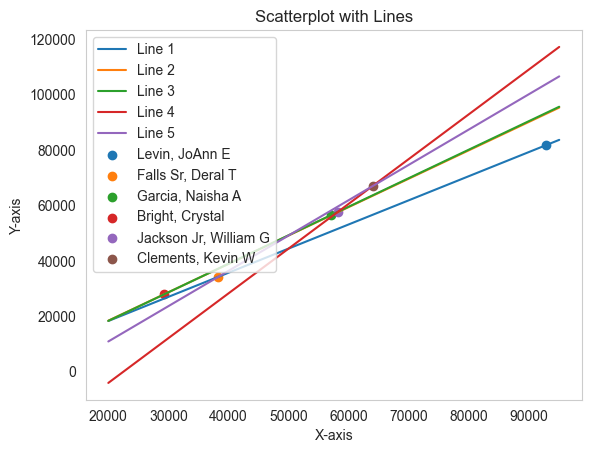

In [10]:
# Scatter points
points = {
    "Levin, JoAnn E": (92800.0, 81736.07),
    "Falls Sr, Deral T": (38318.0, 34251.78),
    "Garcia, Naisha A": (57102.0, 56402.18),
    "Bright, Crystal": (29326.0, 27927.05),
    "Jackson Jr, William G": (58245.0, 57722.89),
    "Clements, Kevin W": (63955.0, 66954.73),
}

# Line equations
lines = [
    {"m": 0.8716, "c": 836.98, "label": "Line 1"},
    {"m": 1.0252, "c": -2116.60, "label": "Line 2"},
    {"m": 1.0303, "c": -2286.25, "label": "Line 3"},
    {"m": 1.6168, "c": -36416.70, "label": "Line 4"},
    {"m": 1.2756, "c": -14634.18, "label": "Line 5"},
]

# Generate x values
x_values = np.linspace(20000, 95000, 500)

# Plot each line
for line in lines:
    y_values = line["m"] * x_values + line["c"]
    plt.plot(x_values, y_values, label=line["label"])

# Plot scatter points
for name, (x, y) in points.items():
    plt.scatter(x, y, label=name)

# Add labels and legend
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Scatterplot with Lines")
plt.legend()
plt.grid()
plt.show()


### Get an estimate

Which was the "middle" slope line on your diagram? i.e., what was the median gradient?

_Answer:_ Since the median is 1.0303 and the closest line with the same slope is line 3 that shows that line 3 is middle slope line

### A moment of reflection

Does that mean that Baltimore employees typically get more pay than their salary, or less than their salary?

_Answer:_ Yes, this shows that Baltimore employees get more gross salary as the median is 1.03

# Data Splitting

We need to have train, validation and test data. (We actually should have done that before we did our manual Theil-Sen algorithm.)

In [11]:
training_data, holdout_data = sklearn.model_selection.train_test_split(salaries, test_size=0.2)
validation_data, test_data = sklearn.model_selection.train_test_split(holdout_data, test_size=0.5)

In [12]:
training_data.shape, validation_data.shape, test_data.shape

((11563, 6), (1445, 6), (1446, 6))

# Scikit Learn Regression

We'll follow the pattern we followed in the code from lectures:

- Construct a Regressor object

- `.fit()` it

- Use it to `.predict()` the validation data

- Look at the coefficients of the model (in this case, the gradient).

### Theil-Sen

Let's see how close your five-sample version was to a more complete computation.

In [13]:
ts = sklearn.linear_model.TheilSenRegressor()
ts.fit(training_data[['AnnualSalary']], training_data['GrossPay'])
ts_predictions = ts.predict(validation_data[['AnnualSalary']])
ts.coef_

P:\OneDrive - Macquarie University\Master's Program\Master UNit guide\COMP6200 - Data Science\WorkShop\data-science-backup\.venv\Lib\site-packages\sklearn\linear_model\_theil_sen.py:128: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn(


array([1.03488776])

### RANSAC

Let's use a RANSAC regressor. Getting the coefficients for a RANSAC model is a little unusual: you ask for the best estimator, and then you ask for the coefficients of that best estimator.

In [14]:
ransac = sklearn.linear_model.RANSACRegressor()
ransac.fit(training_data[['AnnualSalary']], training_data['GrossPay'])
ransac_predictions = ransac.predict(validation_data[['AnnualSalary']])
ransac.estimator_.coef_

array([1.0213288])

### Huber

One of the best and most robust regressors is the Huber model. Finish off this code.

In [15]:
huber = sklearn.linear_model.HuberRegressor()
huber.fit(training_data[['AnnualSalary']], training_data['GrossPay'])
huber_predictions = huber.predict(validation_data[['AnnualSalary']])
huber.coef_


array([0.91084771])

### Ordinary Least Squares

It is very common and popular, so the scikit learn class is called `LinearRegression()`

In [16]:
ols = sklearn.linear_model.LinearRegression()
ols.fit(training_data[['AnnualSalary']], training_data['GrossPay'])
ols_predictions = ols.predict(validation_data[['AnnualSalary']])
ols.coef_

array([1.02360398])

# Evaluating these models

How wrong were the predictions? We can subtract the prediction from the correct answer to look.

In [17]:
validation_data.GrossPay - ts_predictions

Name
Ashenafi,Behailu        -2093.424172
Schley,Michael F         2963.899936
Alsup,Alexis             -735.879066
Campbell Jr,Robert M    -7016.597666
Bell,Terry M            18190.506678
                            ...     
Green,Garnell W        -12993.510854
Hart,Patrick J           7313.505652
Paul,Thomas G             -85.573131
Scott,Gerard W          -6655.599840
Bonsall,Darby M         -2575.076184
Name: GrossPay, Length: 1445, dtype: float64

In [18]:
validation_data.GrossPay - ransac_predictions

Name
Ashenafi,Behailu         -536.442687
Schley,Michael F         4282.189489
Alsup,Alexis              661.052455
Campbell Jr,Robert M    -5554.867875
Bell,Terry M            20061.676386
                            ...     
Green,Garnell W        -10716.751975
Hart,Patrick J           9025.696553
Paul,Thomas G            1795.887827
Scott,Gerard W          -5337.283169
Bonsall,Darby M         -1122.227511
Name: GrossPay, Length: 1445, dtype: float64

Now look at the data for your Huber regressor and your Ordinary Least Squares regressor. (Put the calculations into the next two cells.)

In [19]:
validation_data.GrossPay - huber_predictions

Name
Ashenafi,Behailu           -0.237174
Schley,Michael F         2873.485862
Alsup,Alexis             -106.860839
Campbell Jr,Robert M    -5794.792031
Bell,Terry M            23157.949756
                            ...     
Green,Garnell W         -4315.657707
Hart,Patrick J          10826.579122
Paul,Thomas G            4976.016347
Scott,Gerard W          -6745.765833
Bonsall,Darby M         -1434.516783
Name: GrossPay, Length: 1445, dtype: float64

In [20]:
validation_data.GrossPay - ols_predictions

Name
Ashenafi,Behailu         -411.324922
Schley,Michael F         4447.359616
Alsup,Alexis              813.026507
Campbell Jr,Robert M    -5413.766933
Bell,Terry M            20134.073556
                            ...     
Green,Garnell W        -10712.412424
Hart,Patrick J           9124.770271
Paul,Thomas G            1866.558132
Scott,Gerard W          -5172.117592
Bonsall,Darby M          -979.636323
Name: GrossPay, Length: 1445, dtype: float64

## Summarising how wrong they were

Ideally, we'd like a number that says which one was the best. But choosing which way we calculate that number is a decision
that reflects what we think is important. These are questions we might ask:

- What's the most inaccurate prediction?

- 99% of the time, the correct answer was within ____ of what we predicted?

- On average, how far away from the right answer were we?


Here's how to get the most inaccurate prediction for the Theil-Sen regressor. (The maximum of the absolute values of the error in our prediction.). In the following cells, do RANSAC, Huber and Ordinary Least Squares

In [21]:
(validation_data.GrossPay - ts_predictions).abs().max()

np.float64(156287.98418480967)

In [22]:
(validation_data.GrossPay - ransac_predictions).abs().max()

np.float64(152112.6183659754)

In [23]:
(validation_data.GrossPay - huber_predictions).abs().max()

np.float64(130241.29874525094)

In [24]:
(validation_data.GrossPay - ols_predictions).abs().max()

np.float64(152426.86391660967)

99% of the predictions were wrong by less than this amount… (fill in RANSAC, Huber and Ordinary Least Squares)

In [25]:
(validation_data.GrossPay - ts_predictions).abs().quantile(0.99)

np.float64(45216.003552515875)

In [26]:
(validation_data.GrossPay - ransac_predictions).abs().quantile(0.99)

np.float64(45135.60439026732)

In [27]:
(validation_data.GrossPay - huber_predictions).abs().quantile(0.99)

np.float64(42074.30920633877)

In [28]:
(validation_data.GrossPay - ols_predictions).abs().quantile(0.99)

np.float64(45064.82487705559)

Here's how we could get the mean absolute error (how far we are away from the right answer on average). sklearn has many built-in functions for doing these sorts of calculations. (Fill in RANSAC, Huber and Ordinary Least Squares).

In [29]:
sklearn.metrics.mean_absolute_error(validation_data.GrossPay, ts_predictions)

6633.380887158854

In [30]:
sklearn.metrics.mean_absolute_error(validation_data.GrossPay, ransac_predictions)

6485.0011577774

In [31]:
sklearn.metrics.mean_absolute_error(validation_data.GrossPay, huber_predictions)

6389.698188672716

In [32]:
sklearn.metrics.mean_absolute_error(validation_data.GrossPay, ols_predictions)

6497.775697553018

A very common measure is the $R^2$ measure:

In [33]:
sklearn.metrics.r2_score(validation_data.GrossPay, ts_predictions)

0.7357453436511918

In [34]:
sklearn.metrics.r2_score(validation_data.GrossPay, ransac_predictions)

0.7436997755869692

In [35]:
sklearn.metrics.r2_score(validation_data.GrossPay, huber_predictions)

0.745193147648665

In [36]:
sklearn.metrics.r2_score(validation_data.GrossPay, ols_predictions)

0.743567055337299

## Time to choose!

On the basis of the information you chose above, which regressor are you going to choose to use?


_Answer_: As we can see, that huber model is showing the least error which is equal to 6133.35 in my code.

### Evaluating it

You don't want to run `.fit()` again, but you do want to run `.predict()` again, using the model that you chose in the last section,
but this time using the test data. Call the variable that stores those predictions `test_predictions`.

In [37]:
test_predictions = huber.predict(test_data[['AnnualSalary']])

Using the measure that you thought was the most important—the reason you chose that model over the others—evaluate how good your chosen model is.

i.e., if you thought $R^2$ score was the most important, you would copy that same metric calculation here, comparing `test_data.GrossPay` to `test_predictions`.

In [38]:
test_data.GrossPay - test_predictions

Name
Gilchrist Anders,Donna       29.411353
Gervis,Irene S           -36670.710005
Terry,Michael J           13626.092854
Gentil,Michael C          15178.812768
Fold,Elizabeth R          11959.813100
                              ...     
Murphy,Brandi B            1016.513745
Ford,Jerry D               2643.572945
Shiloh,Laura A            29011.225318
Hopkins,Brian C            2378.063446
Maith,Robert J             4516.183011
Name: GrossPay, Length: 1446, dtype: float64

# A completely different analysis

Now imagine that you are the City of Baltimore's hiring manager. New employees regularly ask how much they are actually likely to earn given the salary to which they are about to agree.

You don't want to give an answer that is too high because you might be putting the city at risk for a lawsuit for misrepresenting the job. On the other hand, you don't want to give an answer that's too low because the candidate might pass up on the job and work elsewhere.

You decide that it will cost \\$0.05 in lawsuit risk for each dollar you overrepresented, but only \\$0.01 for each dollar you underrepresented.

E.g., if a candidate is actually likely to earn \\$100,000, and you say \\$120,000, this is worth \\$10,000 in potential lawsuits for misrepresentation. If you say \\$80,000, then that will cost you \$200 in potential recruiters' fees to find someone else.

Here's a function that will calculate the cost of these predictions. Don't worry if it is too complicated for you to create
by yourself right now, but see if you can make sense of how it works

In [39]:
def cost(actuals, predictions):
    cost = 0.0
    for actual,prediction in zip(actuals, predictions):
        if prediction > actual:
            cost += 0.05 * (prediction - actual)
        elif prediction < actual:
            cost += 0.02 * (actual - prediction)
        else:
            cost += 0.0
    return cost

Here's how you would use it for the Theil-Sen predictions. Use it to calculate the cost of the RANSAC, Huber and Ordinary Least Squares Regressors.

In [40]:
cost(validation_data['GrossPay'], ts_predictions)

np.float64(375702.40723129344)

In [41]:
cost(validation_data['GrossPay'], ransac_predictions)

np.float64(334269.15044504503)

In [42]:
cost(validation_data['GrossPay'], huber_predictions)

np.float64(316349.0421492715)

In [43]:
cost(validation_data['GrossPay'], ols_predictions)

np.float64(332233.730413442)

Based on this, which of the models we created today model would be the best one to use for answering new employees' questions?

_Answer:_ Based on the results above huber model is the best suitable for answering employees' questions regarding gross pay.